In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from random import *
import time

## <span style='color:Gray'> Methods to generate events according to different kind of nuisance parameters  </span>

In [2]:
def Benjamin_one (params) : # parameters : nb_nuisance_values,nb_events_of_each, standard deviation for signal distribution on x axis, standard deviation for signal distribution on y axis, standard deviation for background distribution on x axis, standard deviation for background distribution on y axis 
    try :
        nb_nuisance_values,nb_events_of_each, s_x_w, s_y_w, b_x_w, b_y_w = params
    except :
        print("Can't unpack parameters, make sure to give all of them in the good order")
    Z = [n*np.pi/(2*(nb_nuisance_values-1)) for n in range(0,nb_nuisance_values)]
    DS = np.transpose(np.array([distributions[s_x_distribution](np.cos(Z[0]),s_x_w,nb_events_of_each),distributions[s_y_distribution](np.sin(Z[0]),s_y_w,nb_events_of_each)]))
    DB = np.transpose(np.array([distributions[s_x_distribution](-np.cos(Z[0]),b_x_w,nb_events_of_each),distributions[s_y_distribution](-np.sin(Z[0]),b_y_w,nb_events_of_each)]))
    for k in range(1,nb_nuisance_values) :
        DS = np.concatenate((DS, np.random.multivariate_normal([np.cos(Z[k]),np.sin(Z[k])],[[s_x_w**2,0],[0,s_y_w**2]],nb_events_of_each)))
        DB = np.concatenate((DB, np.random.multivariate_normal([-np.cos(Z[k]),-np.sin(Z[k])],[[b_x_w**2,0],[0,b_y_w**2]],nb_events_of_each)))
    return DS,DB

## <span style='color:Gray'> Setting parameters  </span>

In [17]:
nb_nuisance_values = 3 # The number different value for the nuisance parameter
nb_events_of_each = 500 # The number of signal and background events we generate for each value of the nuisance parameter. In total : there are 2*nb_events_of_each event for each value of the nuisance parameter
nb_events = nb_nuisance_values*nb_events_of_each # The total number of signal events. It is also the total number of background events

distributions = {"poisson" : np.random.poisson,
            "exponential" : np.random.exponential,
            "normal" : np.random.normal} # The available distributions
s_x_distribution, s_y_distribution = "normal","normal" # The kind of distribution we use to generate signal events
b_x_distribution, b_y_distribution = "normal","normal" # The kind of distribution we use to generate background events

methods = {"Benjamin_one" : Benjamin_one} # The method to introduce nuisance parameter. For now, there is only the one describe in Benjamin's paper.
method = "Benjamin_one" # The method we use

params = nb_nuisance_values, nb_events_of_each, 0.7, 0.7, 0.7, 0.7 # The parameters used as input to generate events. See the chosen method for detail
# make sure to set the adequated parameters for the method you choose and in the proper order

## <span style='color:Gray'> Generating & plotting events  </span>

In [18]:
def generate_events (method, params) :
    DS,DB = methods[method](params)
    return DS,DB
DS,DB = generate_events (method, params)

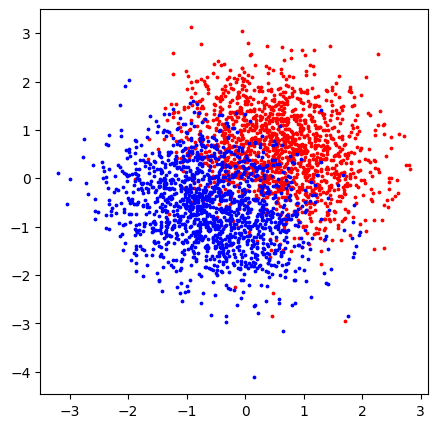

In [67]:
plt.figure(figsize=(5,5))
plt.scatter([a for (a,b) in DS], [b for (a,b) in DS], s = 3, c = "r")
plt.scatter([a for (a,b) in DB], [b for (a,b) in DB], s = 3, c = "b")

## <span style='color:Gray'> Building dataframe  </span>

In [20]:
# Here we make a numpy array with events and associated label to be converted in DataFrame.
points = np.zeros((nb_events,3))
for k in range(int(nb_events/2)) :
    points[2*k][0] = DS[k][0]
    points[2*k][1] = DS[k][1]
    points[2*k][2] = 1
    points[2*k+1][0] = DB[k][0]
    points[2*k+1][1] = DB[k][1]
    points[2*k+1][2] = 0

In [21]:
# Here we make the DataFrame
df = pd.DataFrame(columns=["x","y","class"], data=points, index=range(nb_events))
df.head()

,x,y,class
0,0.520645,-0.501668,1.0
1,-0.036685,-0.459460,0.0
2,1.118165,-0.594032,1.0
3,-0.144042,-0.472059,0.0
4,1.126849,0.672825,1.0


## <span style='color:Gray'> Baseline classifiers  </span>

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df[["x","y"]], df["class"], test_size = 0.25, shuffle = True)

### <span style='color:Gray'> Decision tree  </span>

In [23]:
tree = DecisionTreeClassifier(max_leaf_nodes=8, class_weight="balanced")

In [24]:
tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=8)

AUC score =  0.9608119658119658


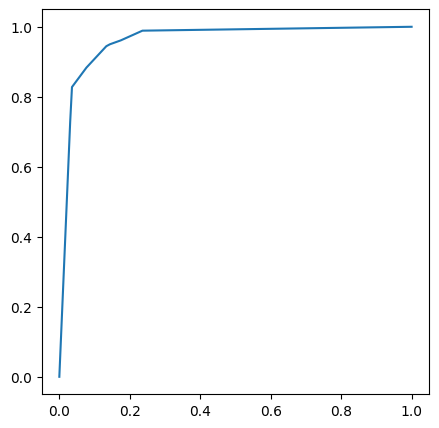

In [68]:
probs = tree.predict_proba(x_test)
sto = []
for i in range(len(y_test)) :
    sto.append(y_test.iloc[i])
probs = probs[:,1]
score = roc_auc_score(sto,probs)
print("AUC score = ", score)

fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr)
plt.savefig("AUCtree.png")

### <span style='color:Gray'>  Deep neural network  </span>

In [59]:
#Setting up the data with numpy arrays for the network 
train_deep = np.zeros((int(0.75*len(DS)) + int(0.75*len(DB)),3))
test_deep = np.zeros((len(DS)+len(DB) - (int(0.75*len(DS)) + int(0.75*len(DB))),3))
for k in range(len(DS)) :
    if k < int(0.75*len(DS)) :
        train_deep[k] = [1,DS[k][0],DS[k][1]]
    else :
        test_deep[k-int(0.75*len(DS))] = [1,DS[k][0],DS[k][1]]
for k in range(len(DB)) :
    if k < int(0.75*len(DB)) :
        train_deep[int(0.75*len(DS))+k] = [0,DB[k][0],DB[k][1]]
    else :
        test_deep[len(DS)-int(0.75*len(DS))+k-int(0.75*len(DB))] = [0,DB[k][0],DB[k][1]]

In [76]:
class Network :
    def __init__ (self,size) :
        self.num_layer = len(size)
        self.taille = size
        self.biais = [np.random.randn(layersize) for layersize in size[1:]]
        self.poids = [np.random.randn(layersize2,layersize1) for layersize1, layersize2 in zip(size[:-1],size[1:])]
    def feedforward (self,a) :
        for b,w in zip(self.biais, self.poids) :
            a = sigmoid(np.dot(w,a) + b)
        return a
    def SGD (self, training_data, epochs, mini_batch_size, eta, finest_eta, test_data = None) :
        n = len(training_data)
        n_test = len (test_data)
        results = []
        for k in range(epochs) :
            np.random.shuffle(training_data)
            mini_batches = [training_data[j:j+mini_batch_size] for j in range(0,n,mini_batch_size)]
            if k > 0 and results[-1]/n_test > 0.5 :
                actual_eta = 10**(2*(np.log10(finest_eta)-np.log10(eta))*(results[-1]/n_test-1)+np.log10(finest_eta))
            else :
                actual_eta = eta
            for mini_batch in mini_batches :
                self.update_mini_batch(mini_batch, actual_eta)
            if type(test_data) != type(None) :
                s, probs = self.evaluate(test_data,results)
                print ("Epoch ", k, " completed : ", s, n_test)
                print ("AUC", roc_auc_score(test_data[:,0], probs[:,1]))
                if k == epochs-1 :
                    fpr, tpr, thresholds = roc_curve(test_data[:,0], probs[:,1])
                    plt.figure(figsize=(5,5))
                    plt.plot(fpr,tpr)
            else :
                print ("Epoch ", k, " completed.")
        #plt.plot(results)
    def update_mini_batch (self, mini_batch, eta) :
        nabla_b = [np.zeros(b.shape) for b in self.biais]
        nabla_w = [np.zeros(w.shape) for w in self.poids]
        for data in mini_batch :
            x,y = data[1:], np.zeros(2)
            y[int(data[0])] = 1
            delta_nabla_b, delta_nabla_w = self.backprop(x,y)
            nabla_b = [nb + db for nb, db in zip(nabla_b,delta_nabla_b)]
            nabla_w = [nw + dw for nw, dw in zip(nabla_w, delta_nabla_w)]
        self.biais = [b-eta/(len(mini_batch))*nb for b, nb in zip(self.biais, nabla_b)]
        self.poids = [w-eta/(len(mini_batch))*nw for w, nw in zip(self.poids, nabla_w)]
    def evaluate (self, test_data, results) :
        s = 0
        probs = np.zeros((len(test_data),2))
        for k in range(len(test_data)) :
            data = test_data[k]
            x,y = data[1:], data[0]
            ff = self.feedforward(x)
            probs[k][0], probs[k][1] = ff[0], ff[1]
            output = np.argmax(ff)
            if output == y :
                s += 1
        results.append(s)
        return s, probs
        output = [(np.argmax(self.feedforward(x)),y) for x,y in zip()]
    def backprop (self,x,y) :
        nabla_b = [np.zeros(b.shape) for b in self.biais]
        nabla_w = [np.zeros(w.shape) for w in self.poids]
        #feedforward
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biais, self.poids) :
            z = np.dot(w,activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        #backprop
        delta = self.cost_derivative(activations[-1],y)*sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        delta2 = np.array([delta,])
        acti2 = np.array([activations[-2],])
        nabla_w[-1] = np.dot(delta2.transpose(), acti2)
        for l in range(2,self.num_layer) :
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.poids[-l+1].transpose(), delta)*sp
            nabla_b[-l] = delta
            deltaT = np.array([delta,])
            actiT = np.array([activations[-l-1],])
            nabla_w[-l] = np.dot(deltaT.transpose(), actiT)
        return (nabla_b, nabla_w)
    def cost_derivative (self, output_activations, y) :
        return output_activations - y

def sigmoid (z) :
    return 1/(1+np.exp(-z*0.1))

def sigmoid_prime (z) :
    return sigmoid(z)*(1-sigmoid(z))


Epoch  0  completed :  571 750
AUC 0.8464853333333332
Epoch  1  completed :  586 750
AUC 0.8579484444444445
Epoch  2  completed :  587 750
AUC 0.8621937777777778
Epoch  3  completed :  591 750
AUC 0.864888888888889
Epoch  4  completed :  590 750
AUC 0.8653937777777778
Epoch  5  completed :  589 750
AUC 0.8655786666666666
Epoch  6  completed :  588 750
AUC 0.8657991111111112
Epoch  7  completed :  592 750
AUC 0.8672924444444443
Epoch  8  completed :  590 750
AUC 0.8672782222222222
Epoch  9  completed :  589 750
AUC 0.8649031111111112
Epoch  10  completed :  593 750
AUC 0.8666951111111111
Epoch  11  completed :  593 750
AUC 0.8664675555555555
Epoch  12  completed :  587 750
AUC 0.8651946666666667
Epoch  13  completed :  591 750
AUC 0.8652302222222222
Epoch  14  completed :  591 750
AUC 0.8666951111111112
Epoch  15  completed :  593 750
AUC 0.8670079999999999
Epoch  16  completed :  591 750
AUC 0.8657137777777777
Epoch  17  completed :  594 750
AUC 0.8672782222222222
Epoch  18  completed 

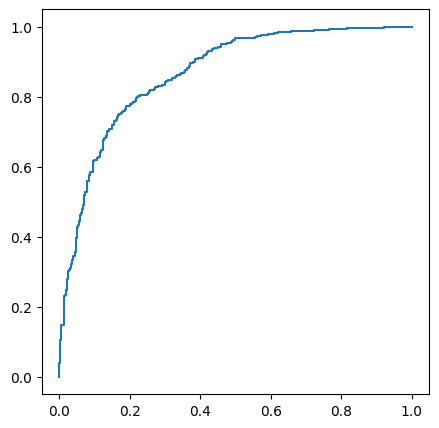

In [75]:
t_ini = time.time()

net1 = Network([2,100,2])
net1.SGD(train_deep, 20, 10, 10, 0.1, test_deep)

t_fin = time.time()

#print(t_fin-t_ini)